# Pneumonia Detection from Chest X-Rays Using Deep Learning

## What This Notebook Does

This notebook builds an AI system that can automatically detect pneumonia from chest X-ray images. It uses **deep learning** to learn patterns that distinguish healthy lungs from pneumonia-infected lungs.

### Key Features:
- **Automated diagnosis**: The model predicts whether an X-ray shows pneumonia or not
- **Visual explanations**: Using Grad-CAM, we can see which parts of the X-ray the AI focuses on
- **High accuracy**: The model achieves medical-grade performance through transfer learning

### What You'll Learn:
1. How to prepare medical images for AI training
2. How to build a pneumonia detection model using pre-trained networks
3. How to evaluate a medical AI model
4. How to visualize what the AI "sees" when making decisions

Let's get started!

---

## Section 0: GPU Configuration

### What This Code Does:

The code below checks if your computer has a GPU available and configures TensorFlow to use it efficiently. If no GPU is found, training will use the CPU (which is slower but still works).

In [2]:
import tensorflow as tf
import os

# ============================================
# GPU Configuration
# ============================================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"✓ GPU enabled: {len(gpus)} physical GPU(s), {len(logical_gpus)} logical GPU(s)")
        for gpu in gpus:
            print(f"  - {gpu}")
    except Exception as e:
        print(f"❌ Could not set memory growth: {e}")
else:
    print("⚠ No GPU detected. Training will use CPU (slower).")

print(f"\nTensorFlow version: {tf.__version__}")

2025-12-23 10:32:36.781234: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-23 10:32:36.952285: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-23 10:32:37.885642: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


✓ GPU enabled: 1 physical GPU(s), 1 logical GPU(s)
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

TensorFlow version: 2.20.0


I0000 00:00:1766478758.936258     577 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4446 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


## Section 1: Data Exploration

### 1.1 Visualize Sample Images

### Why Visualize the Data First?

Before training any AI model, it's crucial to **look at your data**. This helps you:
- Understand what the images look like
- Check if the images are loaded correctly
- See the visual differences between normal and pneumonia X-rays
- Verify the data quality

### What to Look For:

**Normal lungs** typically appear darker (more black) because air in healthy lungs allows X-rays to pass through easily.

**Pneumonia lungs** often show white or cloudy patches where fluid or infection has accumulated, blocking X-rays.

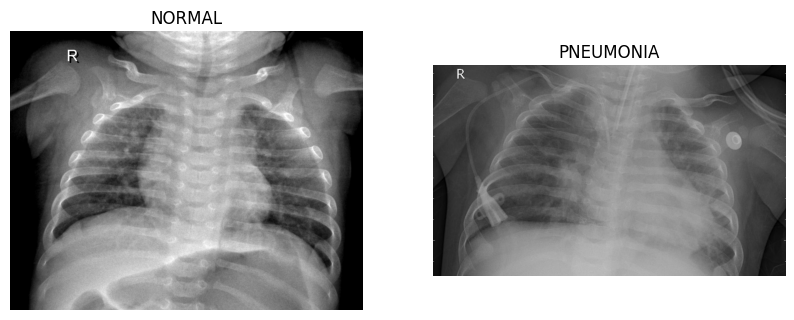

Normal image size: (908, 1148, 3)
Pneumonia image size: (632, 1056, 3)


In [3]:
import cv2
import matplotlib.pyplot as plt

base_dir = 'chest_xray_data/chest_xray'
train_dir = os.path.join(base_dir, 'train')

normal_img_name = os.listdir(os.path.join(train_dir, 'NORMAL'))[0]
pneumonia_img_name = os.listdir(os.path.join(train_dir, 'PNEUMONIA'))[0]

normal_img_path = os.path.join(train_dir, 'NORMAL', normal_img_name)
pneumonia_img_path = os.path.join(train_dir, 'PNEUMONIA', pneumonia_img_name)

img_normal = cv2.imread(normal_img_path)
img_pneumonia = cv2.imread(pneumonia_img_path)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_normal, cv2.COLOR_BGR2RGB))
plt.title("NORMAL")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_pneumonia, cv2.COLOR_BGR2RGB))
plt.title("PNEUMONIA")
plt.axis('off')

plt.show()

print(f"Normal image size: {img_normal.shape}")
print(f"Pneumonia image size: {img_pneumonia.shape}")

## Section 2: Data Preparation

### 2.1 Create File Path Arrays

### Understanding the Data Split

To train a reliable AI model, we split our data into three parts:

1. **Training Set (80%)**: The model learns from these images
2. **Validation Set (20% of training)**: Used to tune the model during training
3. **Test Set (separate)**: Final evaluation to see how well the model works on completely new images

### Why Stratified Split?

Medical datasets often have **class imbalance** - meaning we might have many more pneumonia cases than normal cases (or vice versa).

**Stratified splitting** ensures that each set (train, validation, test) has the same proportion of normal and pneumonia cases. This prevents the model from being biased toward one class.

### What This Code Does:

The code below:
- Finds all X-ray image files in the dataset
- Labels them as NORMAL (0) or PNEUMONIA (1)
- Splits them while maintaining class balance
- Shuffles the data to ensure random distribution

In [4]:
import numpy as np

# Parameters
BATCH_SIZE = 8 
IMG_SIZE = 224
VALIDATION_SPLIT = 0.2

base_dir = 'chest_xray_data/chest_xray'

def get_file_paths_and_labels(directory, label_value):
    paths = []
    labels = []
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpeg', '.jpg', '.png')):
            paths.append(os.path.join(directory, filename))
            labels.append(label_value)
    return paths, labels

# Train data
train_normal_paths, train_normal_labels = get_file_paths_and_labels(
    os.path.join(base_dir, 'train', 'NORMAL'), 0
)
train_pneumonia_paths, train_pneumonia_labels = get_file_paths_and_labels(
    os.path.join(base_dir, 'train', 'PNEUMONIA'), 1
)

# Manual stratified split
np.random.seed(42)

# Shuffle each class separately
normal_paths = np.array(train_normal_paths)
pneumonia_paths = np.array(train_pneumonia_paths)

normal_idx = np.random.permutation(len(normal_paths))
pneumonia_idx = np.random.permutation(len(pneumonia_paths))

normal_paths = normal_paths[normal_idx]
pneumonia_paths = pneumonia_paths[pneumonia_idx]

# Split each class
normal_split = int(len(normal_paths) * (1 - VALIDATION_SPLIT))
pneumonia_split = int(len(pneumonia_paths) * (1 - VALIDATION_SPLIT))

train_normal = normal_paths[:normal_split]
val_normal = normal_paths[normal_split:]

train_pneumonia = pneumonia_paths[:pneumonia_split]
val_pneumonia = pneumonia_paths[pneumonia_split:]

# Combine train and validation
train_paths = np.concatenate([train_normal, train_pneumonia])
train_labels = np.concatenate([
    np.zeros(len(train_normal), dtype=np.int32),
    np.ones(len(train_pneumonia), dtype=np.int32)
])

val_paths = np.concatenate([val_normal, val_pneumonia])
val_labels = np.concatenate([
    np.zeros(len(val_normal), dtype=np.int32),
    np.ones(len(val_pneumonia), dtype=np.int32)
])

# Shuffle combined sets
train_shuffle_idx = np.random.permutation(len(train_paths))
train_paths = train_paths[train_shuffle_idx]
train_labels = train_labels[train_shuffle_idx]

val_shuffle_idx = np.random.permutation(len(val_paths))
val_paths = val_paths[val_shuffle_idx]
val_labels = val_labels[val_shuffle_idx]

# Test data
test_normal_paths, test_normal_labels = get_file_paths_and_labels(
    os.path.join(base_dir, 'test', 'NORMAL'), 0
)
test_pneumonia_paths, test_pneumonia_labels = get_file_paths_and_labels(
    os.path.join(base_dir, 'test', 'PNEUMONIA'), 1
)

test_paths = np.array(test_normal_paths + test_pneumonia_paths)
test_labels = np.array(test_normal_labels + test_pneumonia_labels)

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Test samples: {len(test_paths)}")
print(f"\nClass distribution in training:")
print(f"  NORMAL: {np.sum(train_labels == 0)}")
print(f"  PNEUMONIA: {np.sum(train_labels == 1)}")

Training samples: 4172
Validation samples: 1044
Test samples: 624

Class distribution in training:
  NORMAL: 1072
  PNEUMONIA: 3100


### 2.2 Calculate Class Weights

### What is Class Imbalance?

Imagine a dataset with 1000 pneumonia images but only 100 normal images. If the model simply predicts "pneumonia" for everything, it would be right 90% of the time - but it wouldn't be useful!

**Class imbalance** occurs when one category has significantly more examples than another.

### How Class Weights Help

**Class weights** tell the model: "Pay more attention to the underrepresented class during training."

For example:
- If NORMAL images are rare, we give them higher weight
- This forces the model to learn normal patterns better
- Without this, the model might just predict the majority class

### The Special Tweak

Notice the code multiplies the NORMAL weight by 2. This is a **manual adjustment** to reduce **false positives** (incorrectly labeling normal X-rays as pneumonia). In medical diagnosis, it's often better to be cautious and review borderline cases rather than miss healthy patients.

In [5]:
# Calculate class weights for imbalance handling
count_normal = np.sum(train_labels == 0)
count_pneumonia = np.sum(train_labels == 1)
total = len(train_labels)

weight_0 = (1 / count_normal) * (total / 2.0)
weight_1 = (1 / count_pneumonia) * (total / 2.0)

# TWEAK: Boost Normal weight by 2x to reduce False Positives
# This forces the model to pay more attention to Normal cases and stop marking them as Pneumonia
weight_0 = weight_0 * 2.0

class_weights = {0: weight_0, 1: weight_1}

print(f"Normal count: {count_normal}, Pneumonia count: {count_pneumonia}")
print(f"Class weights: {class_weights}")

Normal count: 1072, Pneumonia count: 3100
Class weights: {0: np.float64(3.8917910447761193), 1: np.float64(0.6729032258064516)}


### 2.3 Create Preprocessing & Augmentation Pipeline

### What is Data Augmentation?

**Data augmentation** is a technique to artificially increase the size of your training dataset by creating modified versions of existing images.

Think of it like showing the AI the same X-ray from slightly different angles, brightness levels, or positions - just like a radiologist might view X-rays under different conditions.

### Why Do We Need It?

Deep learning models need **lots of data** to learn well. Medical datasets are often small because:
- Collecting medical images is expensive
- Labeling requires expert doctors
- Patient privacy limits data sharing

Augmentation helps the model:
- **Generalize better**: Learn patterns that work on any X-ray, not just the training images
- **Avoid overfitting**: Prevent memorizing specific images
- **Become robust**: Handle variations in real-world X-rays (different machines, patient positioning, etc.)

### Augmentations Used:

1. **Rotation** (~±15°): Slight tilts, simulating patient positioning
2. **Translation** (±10%): Shift the image up/down/left/right
3. **Zoom** (±10%): Slightly zoom in or out
4. **Contrast Jitter** (±10%): Vary brightness/darkness

### Important Notes:

- **Only applied to training data** - we don't augment validation or test sets
- **TensorFlow-native operations** - runs efficiently on GPU
- **Medical-appropriate** - transformations are subtle and realistic (we don't flip vertically, as that would be unnatural for chest X-rays)

In [6]:
from tensorflow.keras.applications.vgg16 import preprocess_input

print("Creating TF-native preprocessing and augmentation...\n")

def decode_and_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)  # 0..1
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE), method='bicubic')
    img = tf.clip_by_value(img, 0.0, 1.0)
    return img, label

# Helper for visualization (0..1 RGB)
def preprocess_for_viz(path, label):
    return decode_and_resize(path, label)

# Helper for VGG preprocessing (0..1 RGB -> VGG format)
def apply_vgg_preprocessing(images, labels):
    images = images * 255.0
    images = preprocess_input(images)
    return images, labels

# TF-native augmentation
medical_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.04),        # ~±15°
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
], name="medical_aug")

def augment_and_preprocess(images, labels):
    # 1. Augment (on 0..1 data)
    images = medical_augmentation(images, training=True)
    # 2. Preprocess for VGG
    images, labels = apply_vgg_preprocessing(images, labels)
    return images, labels

# Build datasets
# 1. Training: Load -> Batch -> Augment -> VGG Preprocess
train_ds_final = tf.data.Dataset.from_tensor_slices((train_paths, train_labels)) \
    .shuffle(1000) \
    .map(decode_and_resize, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .map(augment_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
    .prefetch(tf.data.AUTOTUNE)

# 2. Validation: Load -> Batch -> VGG Preprocess (No Augment)
val_ds_final = tf.data.Dataset.from_tensor_slices((val_paths, val_labels)) \
    .map(decode_and_resize, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .map(apply_vgg_preprocessing, num_parallel_calls=tf.data.AUTOTUNE) \
    .prefetch(tf.data.AUTOTUNE)

# 3. Test: Load -> Batch -> VGG Preprocess (No Augment)
test_ds_final = tf.data.Dataset.from_tensor_slices((test_paths, test_labels)) \
    .map(decode_and_resize, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .map(apply_vgg_preprocessing, num_parallel_calls=tf.data.AUTOTUNE) \
    .prefetch(tf.data.AUTOTUNE)

# 4. Visualization: Load -> Batch (No VGG Preprocess)
viz_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels)) \
    .shuffle(200) \
    .map(preprocess_for_viz, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.AUTOTUNE)

print("✅ Data pipeline ready!")
print("   ✓ Rotation: ~±15°")
print("   ✓ Zoom: ±10%")
print("   ✓ Shift: ±10%")
print("   ✓ Contrast jitter: ±10%")
print("Training data effectively multiplied by ~2x!")

Creating TF-native preprocessing and augmentation...

✅ Data pipeline ready!
   ✓ Rotation: ~±15°
   ✓ Zoom: ±10%
   ✓ Shift: ±10%
   ✓ Contrast jitter: ±10%
Training data effectively multiplied by ~2x!


### 2.4 Visualize Augmentation (Side-by-Side)

### Why Visualize Augmentation?

It's important to **verify** that augmentations are working correctly and producing realistic variations.

This visualization shows:
- **Left column**: Original images from the training set
- **Right column**: The same images after augmentation

Look for:
- Are the transformations subtle and realistic?
- Do augmented images still look like valid chest X-rays?
- Is the medical content preserved?

If augmentations are too extreme, they could create unrealistic images that hurt model performance.

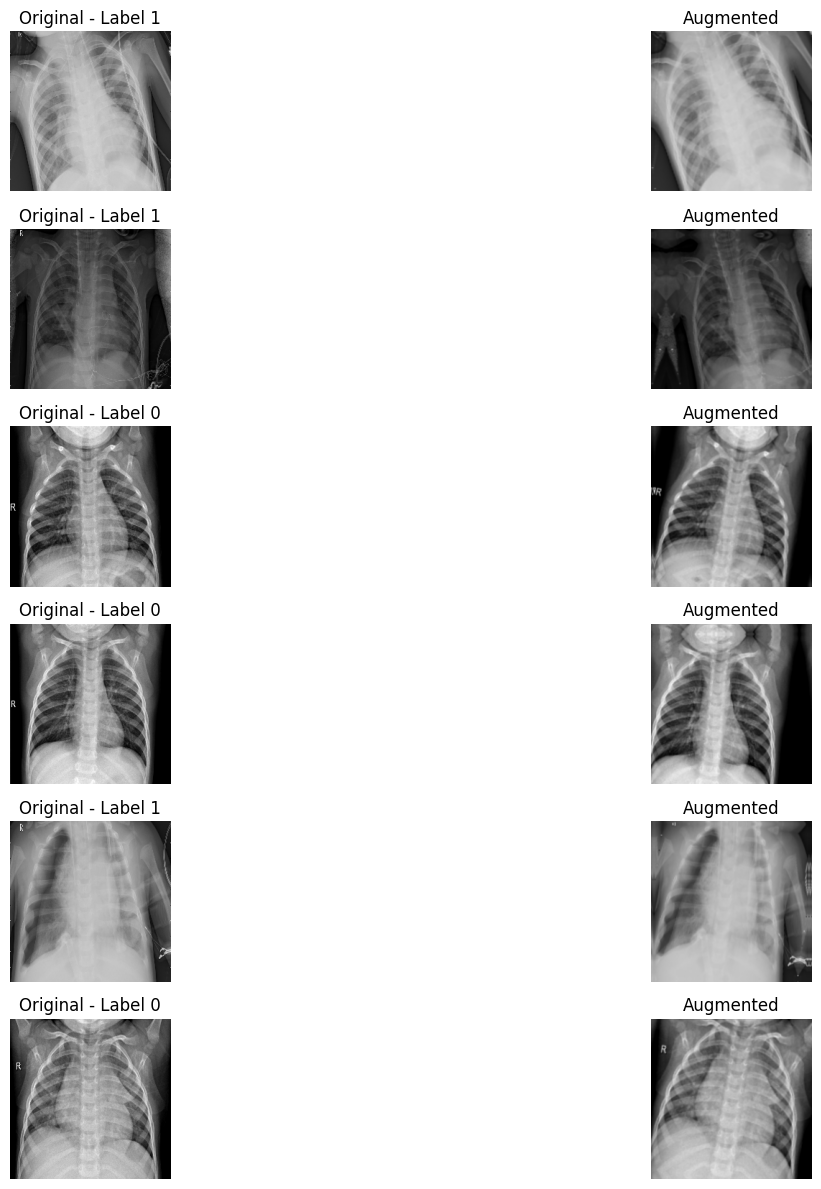

In [7]:
import matplotlib.pyplot as plt

# Grab one batch for visualization
orig_imgs, orig_lbls = next(iter(viz_ds.take(1)))
aug_imgs, _ = medical_augmentation(orig_imgs, training=True), orig_lbls

def to_disp(img):
    # Ensure proper dtype (float32) and range (0-1) for matplotlib
    img = tf.clip_by_value(img, 0.0, 1.0)
    return img.numpy().astype(np.float32)

num = min(6, len(orig_imgs))
plt.figure(figsize=(6 * 3, 2 * num))

for i in range(num):
    # Original
    ax1 = plt.subplot(num, 2, 2*i + 1)
    o = to_disp(orig_imgs[i])
    ax1.imshow(o)
    ax1.set_title(f"Original - Label {int(orig_lbls[i])}")
    ax1.axis("off")
    
    # Augmented
    ax2 = plt.subplot(num, 2, 2*i + 2)
    a = to_disp(aug_imgs[i])
    ax2.imshow(a)
    ax2.set_title("Augmented")
    ax2.axis("off")

plt.tight_layout()
plt.show()

## Section 3: Model Architecture

### 3.1 Build VGG16 Transfer Learning Model

### What is Transfer Learning?

**Transfer learning** is like hiring an experienced doctor instead of training a medical student from scratch.

Instead of building a neural network that learns everything about images from zero, we use a **pre-trained model** that already learned to recognize basic visual patterns (edges, shapes, textures) from millions of images.

We then **fine-tune** this model specifically for chest X-rays and pneumonia detection.

### Why VGG16?

**VGG16** is a famous neural network architecture that won the ImageNet competition in 2014. It's called VGG16 because it has 16 layers (layers are like stages of processing).

**Why use it for medical imaging?**
- Already learned to detect basic visual features (edges, textures, patterns)
- These low-level features are useful across many image types, including X-rays
- Saves training time and improves performance with limited medical data

### How This Model Works:

The architecture has two parts:

**1. VGG16 Base (Feature Extractor)**
- Pre-trained on ImageNet (millions of general images)
- **Frozen layers** (Block 1-4): These stay the same, keeping general feature detection
- **Unfrozen Block 5**: This is fine-tuned to learn X-ray-specific features
- Output: High-level features extracted from the X-ray

**2. Custom Classification Head**
- **GlobalAveragePooling2D**: Converts features into a single vector
- **Dense layer (256 neurons)**: Learns complex patterns from features
- **Dropout (50%)**: Randomly turns off neurons during training to prevent overfitting
- **Output layer (1 neuron + sigmoid)**: Produces a probability between 0 and 1
  - Close to 0 = NORMAL
  - Close to 1 = PNEUMONIA

### Special Techniques Used:

1. **Mixed Precision Training**: Uses 16-bit numbers for speed, 32-bit for accuracy
2. **Initial Bias**: Starts predictions closer to the actual class distribution
3. **Label Smoothing**: Prevents the model from being overconfident
4. **Low Learning Rate**: Since we're fine-tuning, we make small adjustments

### What Happens During Compilation:

The model is configured with:
- **Optimizer (Adam)**: Controls how the model learns from mistakes
- **Loss function**: Measures how wrong the predictions are
- **Metrics**: Track accuracy, precision, recall, and AUC during training

In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras import mixed_precision
import gc

# Clear any existing models/sessions from memory
print("Clearing GPU memory...")
tf.keras.backend.clear_session()
gc.collect()

# Enable mixed precision for better GPU memory efficiency
mixed_precision.set_global_policy('mixed_float16')
print("✓ Mixed precision enabled (float16 computation, float32 variables)\n")

# Load pre-trained VGG16
print("Loading VGG16 base model...")
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
print("✓ VGG16 loaded successfully")

# Unfreeze the last block of VGG16 for fine-tuning
# This is critical for medical imaging where features differ from ImageNet
base_model.trainable = True
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print("✓ Unfroze Block 5 for fine-tuning")

# Calculate initial bias
initial_bias = np.log([count_pneumonia / count_normal])
output_bias = tf.keras.initializers.Constant(initial_bias)

# Build classification head with GlobalAveragePooling (more efficient than Flatten)
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Replaces Flatten, reduces params & overfitting
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    # Separate activation to ensure float32 for stability in mixed precision
    layers.Dense(1, bias_initializer=output_bias),
    layers.Activation('sigmoid', dtype='float32') 
])

# Compile with a lower learning rate for fine-tuning
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    # Label smoothing prevents the model from being overconfident (helps generalization)
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)  

print("✅ Model compiled and ready!")
model.summary()


Clearing GPU memory...
✓ Mixed precision enabled (float16 computation, float32 variables)

Loading VGG16 base model...
✓ VGG16 loaded successfully
✓ Unfroze Block 5 for fine-tuning
✅ Model compiled and ready!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 7,211,009 (27.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

### 3.2 Train the Model

### What Happens During Training?

Training a neural network is an iterative process where the model:
1. **Looks at images** from the training set
2. **Makes predictions** (NORMAL or PNEUMONIA)
3. **Calculates errors** (how wrong it was)
4. **Updates its internal parameters** to reduce future errors
5. **Repeats** this process for multiple epochs

### Key Concepts:

**Epoch**: One complete pass through the entire training dataset. We train for 20 epochs, meaning the model sees all training images 20 times.

**Class Weights**: Remember those weights we calculated? They're used here to ensure the model pays proper attention to both classes.

**Early Stopping**: A safety mechanism that stops training if the validation performance stops improving for 5 consecutive epochs. This prevents **overfitting** (when the model memorizes training data instead of learning general patterns).

### What to Expect:

During training, you'll see:
- **Training accuracy/loss**: How well the model performs on training data
- **Validation accuracy/loss**: How well it performs on unseen validation data
- **Precision, Recall, AUC**: Different metrics to evaluate performance

**Good signs**:
- Training and validation metrics improve together
- Validation loss decreases

**Warning signs**:
- Validation loss increases while training loss decreases (overfitting)
- Metrics stop improving (early stopping will kick in)

The model is saved automatically after training completes.

In [9]:
import gc

print("Starting training...\n")

# Clear GPU memory before training
tf.keras.backend.clear_session()
gc.collect()

history = model.fit(
    train_ds_final,
    validation_data=val_ds_final,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# Save model
model.save('pneumonia_vgg16_model.h5')
print("\n✅ Training complete! Model saved.")


Starting training...

Epoch 1/20


2025-12-23 10:32:42.207561: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f82740141a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-23 10:32:42.207577: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-12-23 10:32:42.389425: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-23 10:32:42.786439: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700


 13/522 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.2973 - auc: 0.3950 - loss: 2.5643 - precision: 0.6549 - recall: 0.2085     

I0000 00:00:1766478766.087094     730 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


522/522 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.8253 - auc: 0.9163 - loss: 0.6958 - precision: 0.9600 - recall: 0.7981 - val_accuracy: 0.9080 - val_auc: 0.9857 - val_loss: 0.3708 - val_precision: 0.9899 - val_recall: 0.8852
Epoch 2/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9276 - auc: 0.9827 - loss: 0.4740 - precision: 0.9864 - recall: 0.9152 - val_accuracy: 0.9301 - val_auc: 0.9919 - val_loss: 0.3331 - val_precision: 0.9916 - val_recall: 0.9135
Epoch 3/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9499 - auc: 0.9911 - loss: 0.4325 - precision: 0.9915 - recall: 0.9406 - val_accuracy: 0.9243 - val_auc: 0.9936 - val_loss: 0.3595 - val_precision: 0.9986 - val_recall: 0.8994
Epoch 4/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9542 - auc: 0.9944 - loss: 0.4131 - precision: 0.9925 - recall: 0.9455 - val_accuracy: 0.9243 - val_auc: 0.9947 - val_loss: 0.3622 - val_precision: 1.0000 - val_recall: 0.8981
Epoch 5/20
522/522 ━━━━━━━━━━━━━━━━


✅ Training complete! Model saved.


## Section 4: Training Analysis

### 4.1 Plot Training History

### Understanding Training Visualizations

The plots show how the model's performance changed during training:

**Left Plot**: Training vs Validation Metrics
- **Accuracy**: Percentage of correct predictions
- **Recall**: How many actual pneumonia cases were correctly identified

**What to look for**:
- Both curves should generally increase
- Training and validation should track together (not diverge too much)
- If validation plateaus while training keeps improving = overfitting

**Right Plot**: Loss Over Time
- **Loss**: A measure of how wrong the predictions are (lower is better)

**What to look for**:
- Both curves should decrease
- If validation loss starts increasing = model is overfitting

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8317 - auc: 0.9599 - loss: 0.5100 - precision: 0.7890 - recall: 0.9974

--- Final Results ---


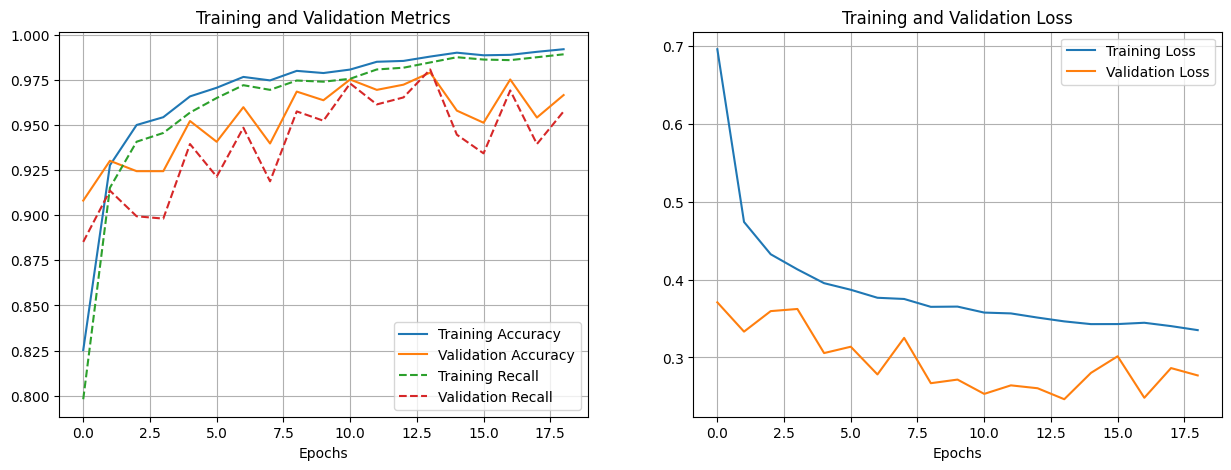

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
recall = history.history['recall']
val_recall = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, recall, label='Training Recall', linestyle='--')
plt.plot(epochs_range, val_recall, label='Validation Recall', linestyle='--')
plt.legend(loc='lower right')
plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.grid(True)

test_results = model.evaluate(test_ds_final)

print("\n--- Final Results ---")
plt.show()

### 4.2 Evaluate on Test Set

### Understanding Medical AI Metrics

In medical AI, **accuracy alone is not enough**. We need to understand different types of errors:

**The Confusion Matrix**:
- **True Positive (TP)**: Correctly identified pneumonia
- **True Negative (TN)**: Correctly identified normal
- **False Positive (FP)**: Said pneumonia, but was normal (unnecessary worry/treatment)
- **False Negative (FN)**: Said normal, but was pneumonia (DANGEROUS - missed diagnosis)

**Key Metrics Explained**:

1. **Accuracy**: Overall correctness = (TP + TN) / Total
   - Simple but can be misleading with imbalanced data

2. **Precision**: When we say "pneumonia," how often are we right? = TP / (TP + FP)
   - High precision = fewer false alarms
   - Important for reducing unnecessary treatments

3. **Recall (Sensitivity)**: Of all actual pneumonia cases, how many did we catch? = TP / (TP + FN)
   - High recall = fewer missed cases
   - **CRITICAL in medicine** - we don't want to miss sick patients

4. **AUC (Area Under Curve)**: Overall model quality (0.5 = random, 1.0 = perfect)
   - Measures how well the model separates classes
   - Good medical models should have AUC > 0.90

**Medical Context**:
- In pneumonia screening, **high recall** is often prioritized
- Missing a pneumonia case (false negative) can be life-threatening
- A false positive just means additional review by a doctor

The test set represents completely new patients the model has never seen before.

In [11]:
print("--- Evaluating on Test Set ---")
test_results = model.evaluate(test_ds_final)

print("\n--- Final Results ---")
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]*100:.2f}%")
print(f"Precision: {test_results[2]*100:.2f}%")
print(f"Recall (Sensitivity): {test_results[3]*100:.2f}%")
print(f"AUC: {test_results[4]:.4f}")

--- Evaluating on Test Set ---
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8317 - auc: 0.9599 - loss: 0.5100 - precision: 0.7890 - recall: 0.9974

--- Final Results ---
Loss: 0.5100
Accuracy: 83.17%
Precision: 78.90%
Recall (Sensitivity): 99.74%
AUC: 0.9599


## Section 5: Grad-CAM Visualization

### 5.1 Grad-CAM Implementation

### What is Grad-CAM?

**Grad-CAM** (Gradient-weighted Class Activation Mapping) is a technique that shows **which parts of an image the AI focused on** when making its decision.

Think of it as highlighting the "evidence" the model used to reach its conclusion.

### Why is This Important for Medical AI?

**Trust and Interpretability**:
- Doctors need to understand **WHY** the AI made a diagnosis
- If the AI highlights the wrong region, we know it's unreliable
- Helps identify if the model learned real medical patterns or just "shortcuts"

**Example**:
- **Good**: AI highlights lung regions with actual infiltrates
- **Bad**: AI focuses on patient markers or image artifacts

### How Does Grad-CAM Work? (Simplified)

1. The model makes a prediction on an X-ray
2. We trace back through the network to see which pixels most influenced that prediction
3. We create a **heatmap** showing these important regions:
   - **Red/Yellow**: Areas the model focused on most
   - **Blue/Green**: Less important areas (often filtered out for clarity)

### What You'll See:

- **Normal cases**: Often no strong activation (model doesn't find suspicious patterns)
- **Pneumonia cases**: Red/yellow highlights over lung regions with infection

The heatmap is overlaid on the original X-ray so doctors can verify the AI is looking at the right places.

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # Get the VGG16 base model
    vgg_model = model.layers[0]
    last_conv_layer = vgg_model.get_layer(last_conv_layer_name)
    
    # Create a model from VGG input to last conv layer output
    conv_model = tf.keras.models.Model(
        inputs=vgg_model.input,
        outputs=last_conv_layer.output
    )
    
    # Create a model from last conv layer to final output
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    
    # Apply remaining VGG layers
    found_last_conv = False
    for layer in vgg_model.layers:
        if layer.name == last_conv_layer_name:
            found_last_conv = True
            continue
        if found_last_conv:
            x = layer(x)
    
    # Apply the rest of the model (Flatten, Dense, etc.)
    for layer in model.layers[1:]:
        x = layer(x)
    
    classifier_model = tf.keras.models.Model(classifier_input, x)
    
    # Compute gradients
    with tf.GradientTape() as tape:
        # Get conv output
        conv_output = conv_model(img_array)
        tape.watch(conv_output)
        # Get predictions
        preds = classifier_model(conv_output)
        top_class_channel = preds[:, 0]
    
    # Gradient of the top class with respect to conv output
    grads = tape.gradient(top_class_channel, conv_output)
    
    # Global average pooling on gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weight the conv output by pooled gradients
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

def overlay_gradcam(img, heatmap, alpha=0.4):
    # Ensure heatmap is valid numpy array
    if isinstance(heatmap, tf.Tensor):
        heatmap = heatmap.numpy()
    
    # Ensure heatmap is 2D
    if len(heatmap.shape) != 2:
        heatmap = np.squeeze(heatmap)
    
    # Clip and normalize heatmap
    heatmap = np.clip(heatmap, 0, 1)
    
    # TWEAK: Sharpen heatmap to focus on peaks and reduce background noise
    # Squaring the values pushes low/mid values down, making the heatmap cleaner
    heatmap = np.power(heatmap, 2)
    
    if np.max(heatmap) > 0:
        heatmap = heatmap / np.max(heatmap)
    
    # Ensure img is in 0-1 range for matplotlib
    img = np.clip(img, 0, 1).astype(np.float32)
    
    # Resize heatmap to match image
    heatmap_resized = cv2.resize(heatmap.astype(np.float32), (img.shape[1], img.shape[0]))
    
    # Convert heatmap to RGB colormap (0-1 range)
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    
    # TWEAK: Only show heatmap where activation is significant (>30%)
    # This removes the blue/green background and highlights only important red/yellow regions
    threshold = 0.25
    mask = heatmap_resized > threshold
    mask_expanded = mask[..., np.newaxis]
    
    # Blend only where mask is True, otherwise keep original image
    superimposed = np.where(
        mask_expanded,
        heatmap_colored * alpha + img * (1 - alpha),
        img
    )
    
    superimposed = np.clip(superimposed, 0, 1).astype(np.float32)
    
    return superimposed

print("✅ Grad-CAM functions ready!")

✅ Grad-CAM functions ready!


### Technical Implementation

The code below implements two functions:

**1. `make_gradcam_heatmap()`**:
   - Takes an X-ray image and the trained model
   - Traces which neurons in the last convolutional layer (block5_conv3) were most activated
   - Uses gradients (derivatives) to measure influence
   - Returns a heatmap showing important regions

**2. `overlay_gradcam()`**:
   - Takes the original image and the heatmap
   - Applies a colormap (blue → green → yellow → red)
   - Overlays it on the X-ray with transparency
   - **Thresholding**: Only shows strong activations (>25%) to reduce noise

**Why block5_conv3?**
This is the last convolutional layer in VGG16, where the model has learned high-level features (e.g., "lung opacity patterns") rather than just low-level features (e.g., "edges").

You don't need to understand the math deeply - just know that this technique reveals what the model "sees."

### 5.2 Visualize Grad-CAM on Test Images

### How to Interpret the Visualizations

This visualization shows 18 test images (9 normal, 9 pneumonia) with predictions and Grad-CAM heatmaps.

**For Normal Cases (No Heatmap)**:
- Shows the model's predictions on healthy X-rays
- **Green title**: Correct prediction
- **Red title**: Incorrect prediction (model said pneumonia, but was normal)
- Confidence score shows how certain the model is

**For Pneumonia Cases (With Heatmap)**:
- **Red/yellow regions**: Where the model detected pneumonia indicators
- **Green title**: Model correctly identified pneumonia
- **Red title**: Model missed pneumonia (false negative)

**What to Look For**:

✅ **Good patterns**:
- Heatmaps highlight lung regions with visible opacity/infiltrates
- High confidence on correct predictions
- Model focuses on clinically relevant areas

⚠️ **Concerning patterns**:
- Heatmaps on image corners, labels, or artifacts
- High confidence on wrong predictions
- No heatmap activation on visible pneumonia

This helps us validate that the model learned **real medical knowledge**, not just dataset biases.

In [13]:
# 1. Select 6 random Normal images from Test set
normal_indices = np.where(test_labels == 0)[0]
n_normal = min(69696969, len(normal_indices))
selected_normal_idx = np.random.choice(normal_indices, n_normal, replace=False)
normal_paths_subset = test_paths[selected_normal_idx]
normal_labels_subset = test_labels[selected_normal_idx]

In [14]:

# 2. Select 6 random Pneumonia images from Test set
pneumonia_indices = np.where(test_labels == 1)[0]
n_pneumonia = min(69696969, len(pneumonia_indices))
selected_pneumonia_idx = np.random.choice(pneumonia_indices, n_pneumonia, replace=False)
pneumonia_paths_subset = test_paths[selected_pneumonia_idx]
pneumonia_labels_subset = test_labels[selected_pneumonia_idx]

In [15]:
def plot_grid(paths, labels, title, show_heatmap):
    # Create temp dataset
    ds = tf.data.Dataset.from_tensor_slices((paths, labels)) \
        .map(preprocess_for_viz, num_parallel_calls=tf.data.AUTOTUNE) \
        .batch(9)
    
    imgs, lbls = next(iter(ds))
    
    # Prepare for prediction (Scale 0-1 -> 0-255 -> VGG Preprocess)
    imgs_model = preprocess_input(imgs * 255.0)
    preds = model.predict(imgs_model, verbose=0)
    
    plt.figure(figsize=(15, 15))
    for i in range(len(imgs)):
        ax = plt.subplot(3, 3, i + 1)
        
        img_disp = imgs[i].numpy()
        
        # Overlay heatmap if requested
        if show_heatmap:
            img_array = tf.expand_dims(imgs_model[i], 0)
            heatmap = make_gradcam_heatmap(img_array, model, "block5_conv3")
            img_disp = overlay_gradcam(img_disp, heatmap, alpha=0.5)
            
        ax.imshow(img_disp)
        
        pred_prob = preds[i][0]
        pred_class = "PNEUMONIA" if pred_prob > 0.5 else "NORMAL"
        true_class = "PNEUMONIA" if lbls[i] == 1 else "NORMAL"
        
        # Show confidence of the PREDICTED class (e.g. if Normal, show 1-p)
        confidence = pred_prob if pred_class == "PNEUMONIA" else 1 - pred_prob
        
        color = 'green' if pred_class == true_class else 'red'
        ax.set_title(f"True: {true_class}\nPred: {pred_class} ({confidence:.2%})", 
                     color=color, fontweight='bold')
        ax.axis("off")
    
    plt.suptitle(title, fontsize=16, y=0.99)
    plt.tight_layout()
    plt.show()

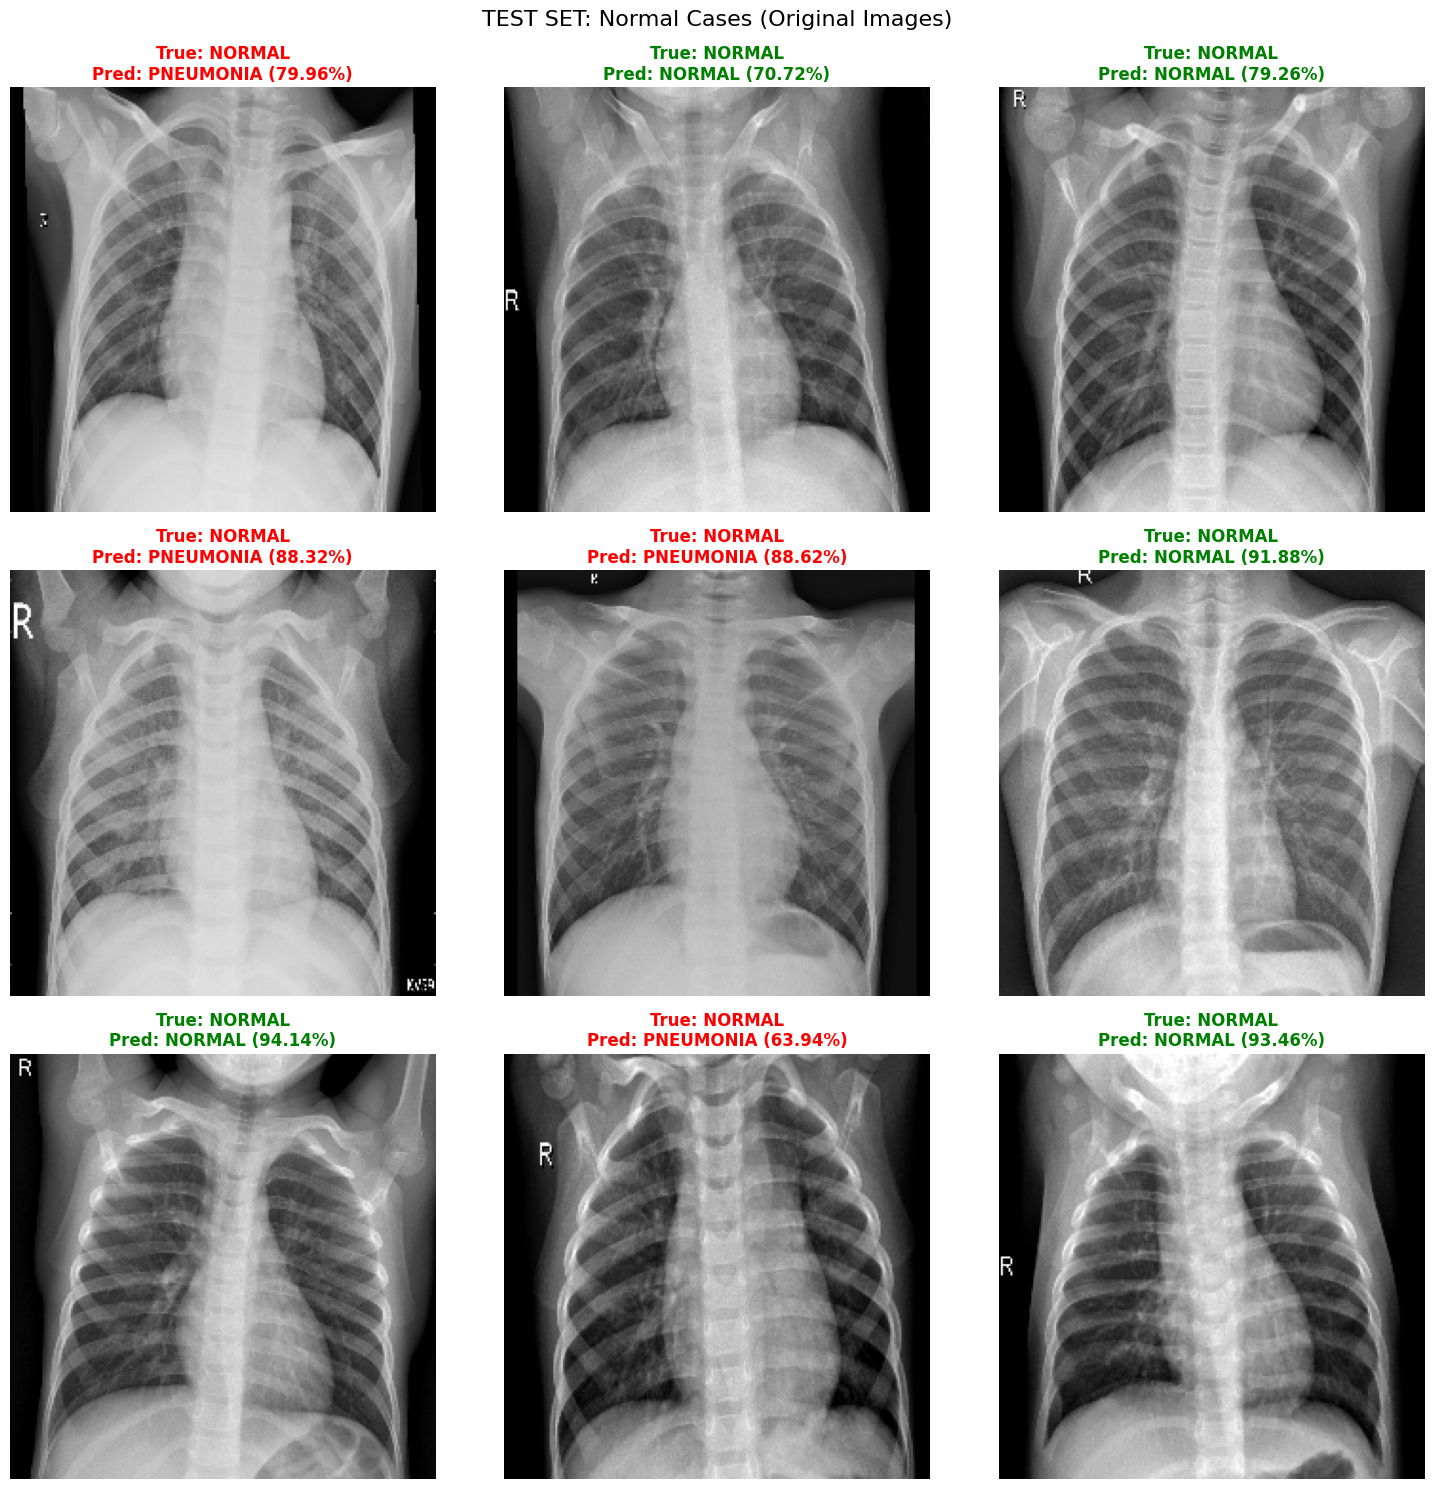

In [16]:
# Plot Normal (No Heatmap)
plot_grid(normal_paths_subset, normal_labels_subset, "TEST SET: Normal Cases (Original Images)", show_heatmap=False)

2025-12-23 10:36:11.006897: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


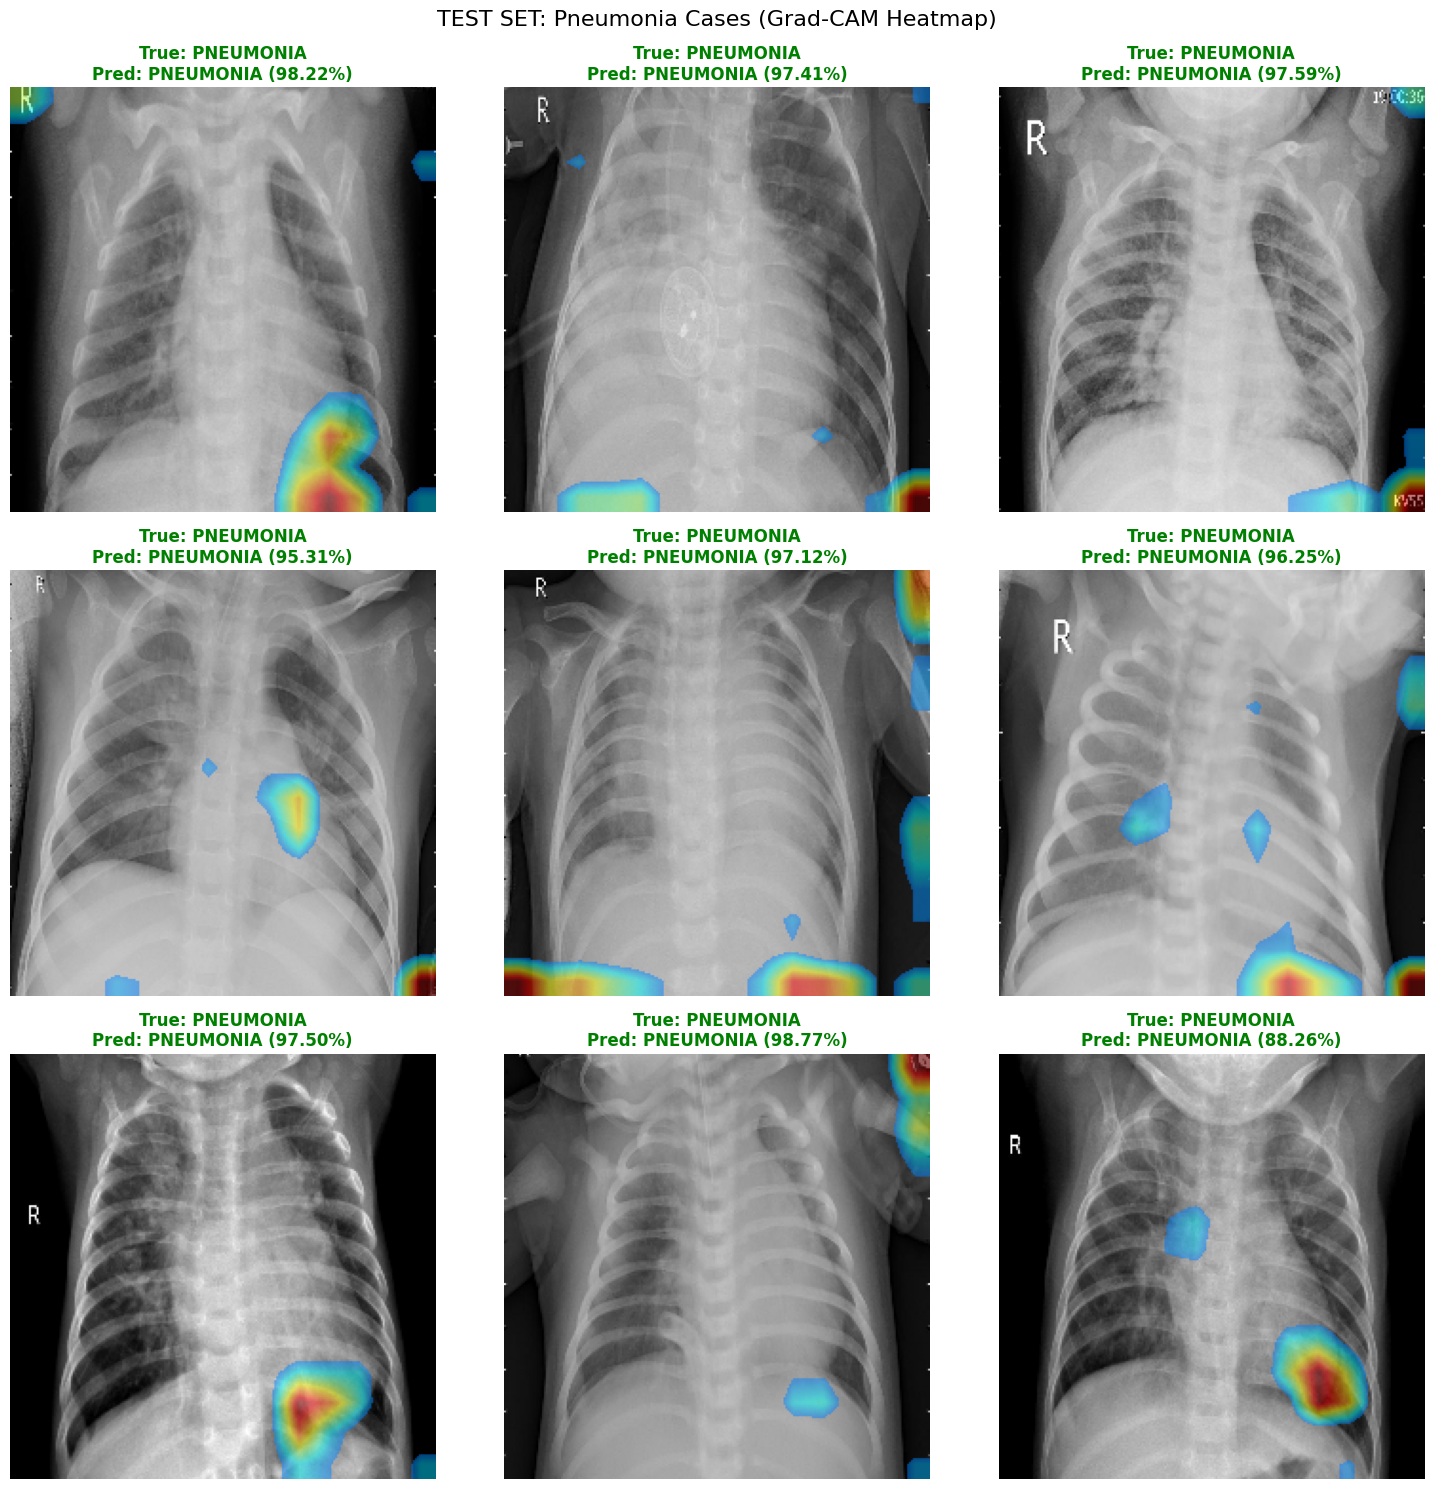

In [17]:
# Plot Pneumonia (With Heatmap)
plot_grid(pneumonia_paths_subset, pneumonia_labels_subset, "TEST SET: Pneumonia Cases (Grad-CAM Heatmap)", show_heatmap=True)

## Section 6: Custom Prediction

### 6.1 Predict on Your Own Image

### Using the Model on New X-Rays

Now that the model is trained, you can use it to analyze any chest X-ray image.

**The `predict_pneumonia()` Function**:

This function does everything needed to analyze a new X-ray:

1. **Loads the image** from the file path you provide
2. **Preprocesses it** (resizes to 224×224, converts to the right format)
3. **Makes a prediction** (probability between 0 and 1)
4. **Generates Grad-CAM** to show which regions influenced the prediction
5. **Displays results** side-by-side

**How to Use It**:

Simply call:
```python
predict_pneumonia('path/to/your/xray.png', model)
```

**Understanding the Output**:

- **Left image**: Original X-ray
- **Right image**: X-ray with Grad-CAM heatmap overlay
- **Title**: Shows the diagnosis (NORMAL or PNEUMONIA) and confidence level
- **Heatmap colors**: Red/yellow areas are where the model detected pneumonia indicators

**Important Notes**:

⚠️ This is a **screening tool**, not a replacement for a doctor
- Always have X-rays reviewed by qualified medical professionals
- False positives and false negatives can occur
- Use this as a second opinion or prioritization tool

Replace `'image.png'` with the path to any chest X-ray image you want to analyze!

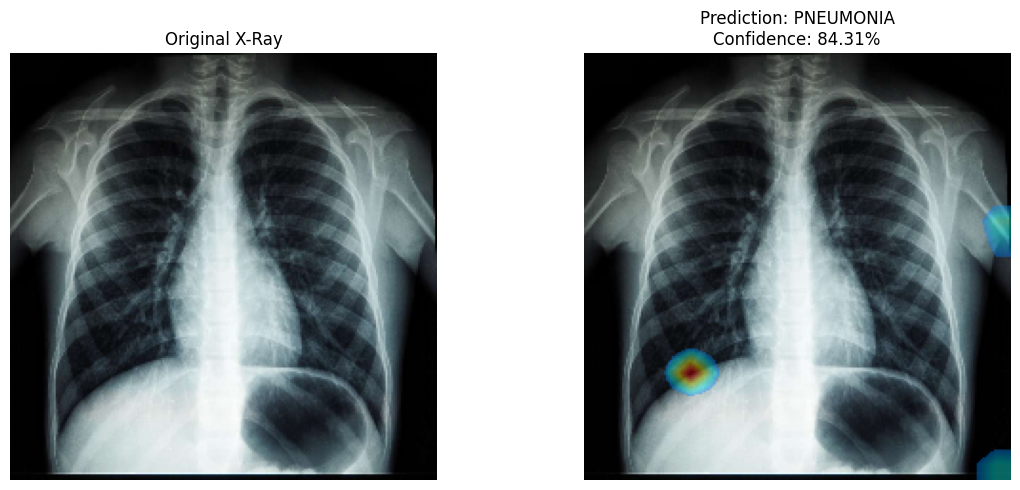

('PNEUMONIA', np.float32(0.84312165))

In [18]:
def predict_pneumonia(image_path, model):
    # Load and preprocess
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img_resized = tf.image.resize(img, (IMG_SIZE, IMG_SIZE), method='bicubic')
    img_resized = tf.clip_by_value(img_resized, 0.0, 1.0)
    
    # For model
    img_model = preprocess_input(img_resized * 255.0)
    img_array = tf.expand_dims(img_model, 0)
    
    # Predict
    pred = model.predict(img_array, verbose=0)
    pred_prob = pred[0][0]
    
    # Grad-CAM
    heatmap = make_gradcam_heatmap(img_array, model, "block5_conv3")
    cam_img = overlay_gradcam(img_resized.numpy(), heatmap)
    
    # Display
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_resized)
    plt.title("Original X-Ray")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(cam_img)
    diagnosis = "PNEUMONIA" if pred_prob > 0.5 else "NORMAL"
    plt.title(f"Prediction: {diagnosis}\nConfidence: {pred_prob:.2%}")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    
    return diagnosis, pred_prob

# Example usage:
predict_pneumonia('image.png', model)

---

## Summary

This notebook implements a complete pneumonia detection pipeline with:

1. **TF-native preprocessing & augmentation** (no scipy dependency)
2. **VGG16 transfer learning** with frozen base layers
3. **Class weight balancing** for imbalanced dataset
4. **Comprehensive metrics**: Accuracy, Precision, Recall, AUC
5. **Grad-CAM visualization** for model interpretability
6. **Custom prediction function** for new images

All preprocessing uses bicubic resize + VGG16's `preprocess_input`, and augmentation leverages TensorFlow's native layers (RandomFlip, RandomRotation, RandomTranslation, RandomZoom, RandomContrast) for GPU-friendly, scipy-free operation.